<a href="https://colab.research.google.com/github/RomanGaraev/AML-DS-2021/blob/main/%22Midterm_Lab_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <center>Midterm Lab
```
- Advanced Machine Learning, Innopolis University 
- Professor: Muhammad Fahim 
- Teaching Assistant: Gcinizwe Dlamini
```
<hr>

```
Tasks:
  1. Image Transform (5 points)
  2. CNN model declaration (10 points)
  3. CNN model training (5 points)
  4. Transfer Learning or Viterbi algorithm : Bonus (5 points)
```

<hr>

## The Dataset

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Task 1 : Preprocessing of Dataset (5 points)

1.   Create the transforms:
    * Resize images to (32 * 32)
    * Normalize every channel (mean and std of your choice)
    * Apply one more data augmentation technique you know (i.e Rotation, translation, RandomErasing, RandomHorizontalFlip etc.)


**Hint**: data augmentation techniques shouldn't be applied to the test dataset.

In [5]:
transform_train =  transforms.Compose([transforms.ToTensor(), transforms.Resize((32,32)),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                       transforms.RandomRotation(10)])

transform_test = transforms.Compose([transforms.ToTensor(),transforms.Resize((32,32)),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

trainset = torchvision.datasets.SVHN(root='./data/train', split="train", download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=1)

testset = torchvision.datasets.SVHN(root='./data/test', split="test", download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=1)

classes = [f"{i}" for i in np.unique(trainset.labels)]

Using downloaded and verified file: ./data/train/train_32x32.mat
Using downloaded and verified file: ./data/test/test_32x32.mat


## Task 1.1 Plot Classes distribution 

Plot the distribution of classes in the training sample on a bar graph

<BarContainer object of 10 artists>

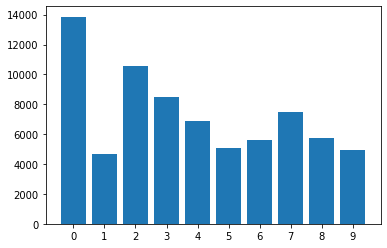

In [95]:
from matplotlib import pyplot as plt
from collections import Counter
#TODO: Plot the distribution of classes

amount = list(dict(Counter(trainset.labels)).values())
plt.bar(classes,height=amount)

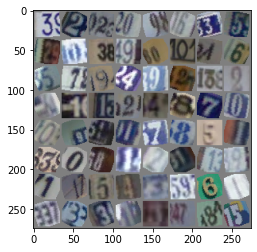

In [4]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 32, 32)
    return x

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# sample a batch and show 
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

## Task 2 : Build a classisfication convolutional neural network


The Model should should have the following achitecture : 
1. 3 Convolution layers : (5 points)
    * conv1 : 2 kernels, 3*3 kernel size, stride 1.
    * conv2 : 4 kernels, 5*5 kernel size, stride 2.
    * conv3 : 8 kernels, 3*3 kernel size, stride 1.
    * Add 1 Avarage pooling layer after 2nd layer and 1 Max-pooling layer before the fully connected layers.
    * Stride for all pooling operations set to 1 
    
    
2. Fully connected layers : 
    * fc1 : 64 output-neurons with a relu activation.
    * output_layer : final layer with no activation function
    * Add Dropout layer after the first (fc1) layer with 25% dropout probability

3. Implement the foward pass method for the CNN  (5 points)
    * Add an activation function of your own choice after every layer
    

In [70]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 2, kernel_size=(3,3))
        self.conv2 = nn.Conv2d(2, 4, kernel_size=(5,5), stride=2)
        self.avg_pool = nn.AvgPool2d((2,2), stride=1)
        self.conv3 = nn.Conv2d(4, 8, kernel_size=(3,3))
        self.max_pool = nn.MaxPool2d((2, 2), stride=1)

        self.fc1 = nn.Linear(8*9*9, 64)
        self.dropout = nn.Dropout(0.25)
        self.output = nn.Linear(64, 10)
        #TODO: Declare the model layers

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.avg_pool(F.relu(self.conv2(x)))
        x = self.avg_pool(F.relu(self.conv3(x)))
        x = x.view(-1, 8*9*9)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.output(x)
        # TODO: Implement the forward pass
        
        return x

## Task 3 : Convolutional neural network training precedure (5 points)

Implement the model training procedure and select the appropriate loss function

In [7]:
# Model accuracy calculator 
def accuracy_calc(net,testloader,device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return correct / total

In [71]:
model = Net().to(device)
model

Net(
  (conv1): Conv2d(3, 2, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(2, 4, kernel_size=(5, 5), stride=(2, 2))
  (avg_pool): AvgPool2d(kernel_size=(2, 2), stride=1, padding=0)
  (conv3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (max_pool): MaxPool2d(kernel_size=(2, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=648, out_features=64, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (output): Linear(in_features=64, out_features=10, bias=True)
)

In [78]:
#Set hyper parameters 
nb_epoch = 3
# Change this parameter to get faster convergence 
lr = 0.01

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
criterion = nn.CrossEntropyLoss() #TODO: Define the Loss function (criterion)

def train(model,trainloader,optimizer, criterion, device):
    #TODO : Implement the training procedure of the model at each an every epoch. It should return model loss and accuracy on training sample
    train_loss = 0
    for X, y in trainloader:
        X, y = X.to(device), y.to(device)
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
    acc = 0
    with torch.no_grad():
        acc = accuracy_calc(model, trainloader, device)
    return train_loss / len(trainloader), acc

In [79]:
for epoch in range(nb_epoch):
    epochLoss, epochAcc = train(model,trainloader, optimizer, criterion, device)
    print(f"Epoch : {epoch}, Loss {epochLoss}, Accuracy {epochAcc}")

Epoch : 0, Loss 1.3348102089098968, Accuracy 0.7006019902534911
Epoch : 1, Loss 0.844136028701041, Accuracy 0.7732912895695975
Epoch : 2, Loss 0.704455764038594, Accuracy 0.7830377984356444


## Task 4 (bonus) : Use pretrained CNN model or Viterbi implementation (5 points)

**Option 1** : Import any pretrained model and train on CIFAR10. Print out the loss and accuracy at each an every epoch. Number of training epochs and optimizer are of your choice. <br>
**OPtion 2** : Implement the viterbi algorithm (from previous lab task POS tagging) 

In [102]:
# Option 1

from torchvision import models

transform_train_1 =  transforms.Compose([transforms.ToTensor(), transforms.Resize((256,256)),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                       transforms.RandomRotation(15),
                                       transforms.RandomHorizontalFlip()])

transform_test_1 = transforms.Compose([transforms.ToTensor(),transforms.Resize((32,32)),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train_1)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test_1)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)



class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.net = models.resnet50(pretrained=True, progress=True)
        self.net.trainable = False
        self.net.fc = nn.Linear(2048, 10)

    def forward(self, x):
        return self.net(x)


net = Net2()
net = net.to(device)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
nb_epoch = 30
lr = 0.01

optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
criterion = nn.CrossEntropyLoss() #TODO: Define the Loss function (criterion)

for epoch in range(nb_epoch):
    if epoch > 10: 
        net.net.trainable = True
        for param_group in optimizer.param_groups:
          param_group['lr'] = lr / 10
    elif epoch > 20:
        # LR shreduler
        for param_group in optimizer.param_groups:
          param_group['lr'] = lr / 100
    epochLoss, epochAcc = train(net,trainloader, optimizer, criterion, device)
    print(f"Epoch : {epoch}, Loss {epochLoss}, Accuracy {epochAcc}")